In [1]:
%matplotlib inline

In [2]:
import moabb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from moabb.evaluations import WithinSessionEvaluation, CrossSubjectEvaluation
from moabb.paradigms import SSVEP, FilterBankSSVEP
from moabb.datasets import SSVEPExo
from moabb.pipelines import SSVEP_CCA, ExtendedSSVEPSignal
from sklearn.pipeline import make_pipeline
from pyriemann.estimation import Covariances
from pyriemann.classification import MDM

# import warnings
# warnings.filterwarnings("ignore")

# Loading dataset

We will load the data from the first 2 subjects of the SSVEP_Exo dataset
and compare two algorithms on this set. One of the algorithm could only
process class associated with a stimulation frequency, we will thus drop
the resting class. As the resting class is the last defined class, picking
the first three classes (out of four) allows to focus only on the stimulation
frequency.

In [3]:
dataset = SSVEPExo()
paradigm = SSVEP(fmin=10, fmax=25, n_classes=3)
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=3)

Choosing the first 3 classes from all possible events
Choosing the first 3 classes from all possible events


Classes are defined by the frequency of the stimulation, here we use
the first two frequencies of the dataset, 13 and 17 Hz.
The evaluation function uses a LabelEncoder, transforming them
to 0 and 1

In [4]:
interval = dataset.interval
freqs = paradigm.used_events(dataset)
print(freqs)

{'13': 2, '17': 3, '21': 4}


# Create pipelines

Pipelines must be a dict of sklearn pipeline transformer.
The first pipeline uses Riemannian geometry, by building an extended
covariance matrices from the signal filtered around the considered
frequency and applying a logistic regression in the tangent plane.
The second pipeline relies on the above defined CCA classifier.

In [5]:
pipelines_fb = {}
pipelines_fb['MDM Euclidean'] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator='lwf'),
    MDM(metric='euclid')
)
pipelines_fb['MDM AIR'] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator='lwf'),
    MDM(metric='riemann')
)
pipelines_fb['MDM Log-Euclidean'] = make_pipeline(
    ExtendedSSVEPSignal(),
    Covariances(estimator='lwf'),
    MDM(metric='logdet')
)

pipelines = {}
pipelines['CCA'] = make_pipeline(
    SSVEP_CCA(interval=interval, freqs=freqs, n_harmonics=3))

# Offline evaluation

We define the paradigm (SSVEP) and use the dataset available for it.
The evaluation will return a dataframe containing a single AUC score for
each subject / session of the dataset, and for each pipeline.

Results are saved into the database, so that if you add a new pipeline, it
will not run again the evaluation unless a parameter has changed. Results can
be overwritten if necessary.

In [6]:
evaluation = WithinSessionEvaluation(paradigm=paradigm,
                                     datasets=dataset, overwrite=True)
results = evaluation.process(pipelines)

Filter bank processing, determine automatically the filter from the stimulation frequency values of events.

In [7]:
evaluation_fb = WithinSessionEvaluation(paradigm=paradigm_fb,
                                        datasets=dataset, overwrite=True)
results_fb = evaluation_fb.process(pipelines_fb)

After processing the two, we simply concatenate the results.

In [8]:
results = pd.concat([results, results_fb])

Separate results based on the kind of approach, plot results with box plot and swarmplots.

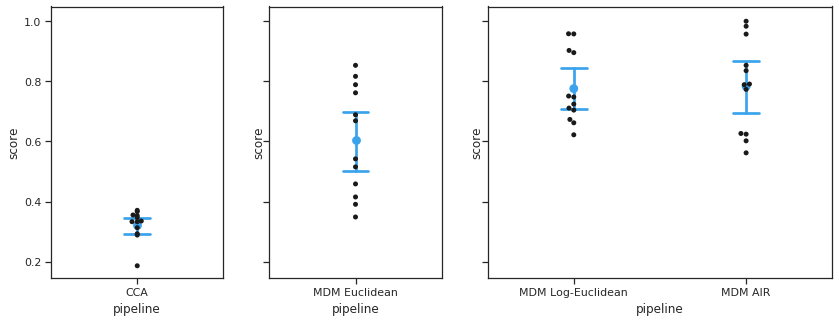

In [9]:
results["kind"] = "Riemannian"
results.loc[results["pipeline"] == "CCA", "kind"] = "CCA"
results.loc[results["pipeline"] == "MDM Euclidean", "kind"] = "Euclidean"


sns.set_style('ticks')
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True,
                      gridspec_kw={'width_ratios': [1, 1, 2]})
kind = ["CCA", "Euclidean", "Riemannian"]
for a, k in zip(axs, kind):
    # a = sns.boxplot(x="pipeline", y="score", width=0.3, data=results[results["kind"] == k], color='C4', ax=a)
    a = sns.pointplot(x="pipeline", y="score", join=False, capsize=.15,
                     data=results[results["kind"] == k], 
                     color='C4', ax=a)
    a = sns.swarmplot(x="pipeline", y="score",
                       data=results[results["kind"] == k], 
                       color=".1", ax=a)

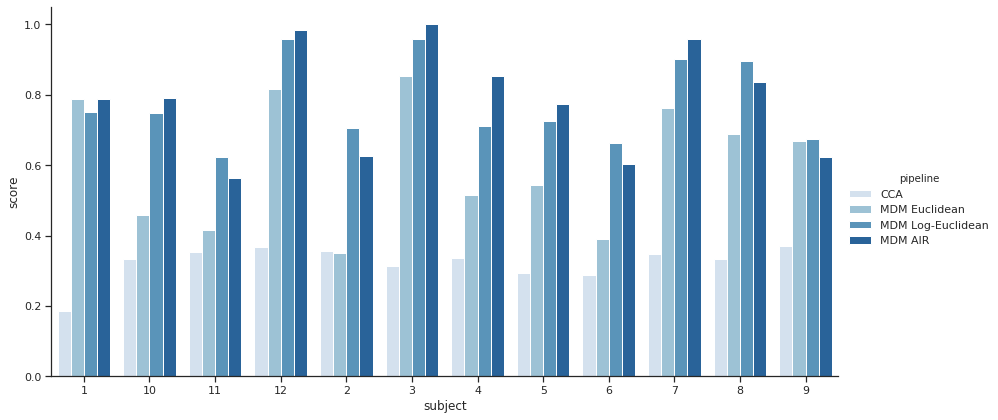

In [10]:
sns.catplot(kind="bar", x="subject", y="score", hue="pipeline",
            hue_order=['CCA', 'MDM Euclidean', 'MDM Log-Euclidean', 'MDM AIR'], 
            height=6, aspect=2, palette="Blues", data=results)

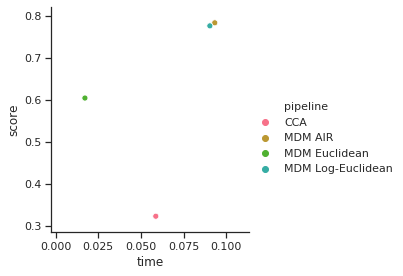

In [11]:
resmoy = results[["pipeline", "score", "time"]].groupby("pipeline").mean().reset_index()
sns.relplot(kind="scatter", x="time", y="score", hue="pipeline", data=resmoy, height=4)

# Cross-subject results

In this analysis, 4 classes are considered including the resting class. The evaluation is conducted with a cross-subject, or Leave-One-Subject-Out, approach. 

In [12]:
paradigm = SSVEP(fmin=10, fmax=25, n_classes=None)
paradigm_fb = FilterBankSSVEP(filters=None, n_classes=None)
interval = dataset.interval
freqs = paradigm.used_events(dataset)
print(freqs)

evaluation = CrossSubjectEvaluation(paradigm=paradigm,
                                     datasets=dataset, overwrite=True)
results = evaluation.process(pipelines)
evaluation_fb = CrossSubjectEvaluation(paradigm=paradigm_fb,
                                        datasets=dataset, overwrite=True)
results_fb = evaluation_fb.process(pipelines_fb)
results = pd.concat([results, results_fb])

Choosing the first None classes from all possible events
Choosing the first None classes from all possible events


{'13': 2, '17': 3, '21': 4, 'rest': 1}


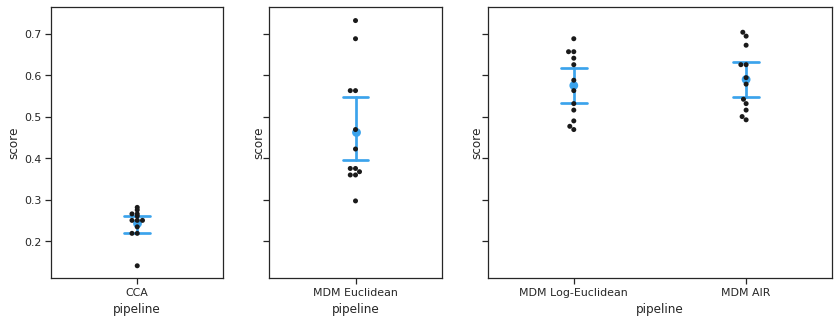

In [13]:
results["kind"] = "Riemannian"
results.loc[results["pipeline"] == "CCA", "kind"] = "CCA"
results.loc[results["pipeline"] == "MDM Euclidean", "kind"] = "Euclidean"


sns.set_style('ticks')
f, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True,
                      gridspec_kw={'width_ratios': [1, 1, 2]})
kind = ["CCA", "Euclidean", "Riemannian"]
for a, k in zip(axs, kind):
    # a = sns.boxplot(x="pipeline", y="score", width=0.3, data=results[results["kind"] == k], color='C4', ax=a)
    a = sns.pointplot(x="pipeline", y="score", join=False, capsize=.15,
                     data=results[results["kind"] == k], 
                     color='C4', ax=a)
    a = sns.swarmplot(x="pipeline", y="score",
                       data=results[results["kind"] == k], 
                       color=".1", ax=a)

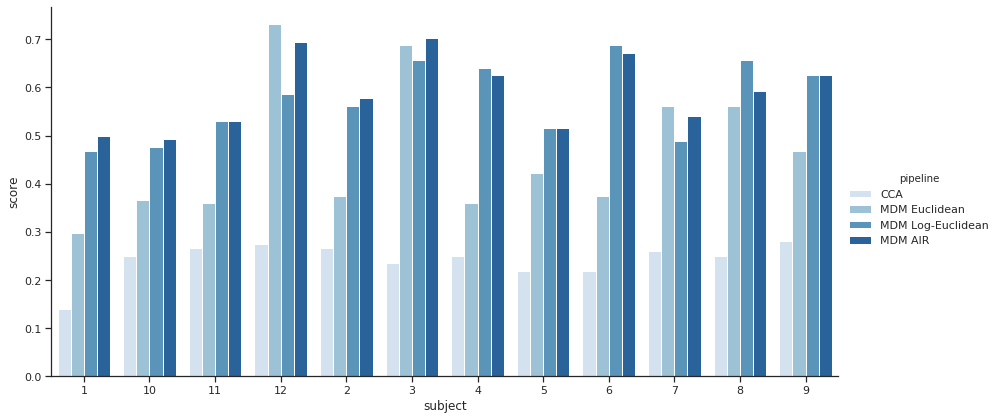

In [14]:
sns.catplot(kind="bar", x="subject", y="score", hue="pipeline",
            hue_order=['CCA', 'MDM Euclidean', 'MDM Log-Euclidean', 'MDM AIR'], 
            height=6, aspect=2, palette="Blues", data=results)